In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle as pkl
import numpy as np
import sys

sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/DMfit/DMfit")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/PDFs")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/DetResponse")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/Utils")

from Detector import *
from Plot_Histogram import *
from Interpolate import *
from Utils import *
from Signal import *


# KDE:
from KDEpy import FFTKDE
from KDEpy.bw_selection import improved_sheather_jones

In [2]:
# Compute the response matrix in logEreco, logEtrue, logpsitrue and logpsireco

NEreco = 100
NEtrue = 200
Npsitrue = 100
Npsireco = 50
maxEtrue = 3000
maxEreco = 1000

logEtrue = np.linspace(np.log10(1e-3), np.log10(maxEtrue), NEtrue)
logEreco = np.linspace(np.log10(1e-3), np.log10(maxEreco), NEreco)
logpsitrue = np.linspace(np.log(1e-5), np.log(180), Npsitrue)
logpsireco = np.linspace(np.log(1e-5), np.log(180), Npsireco)

g_psi_true, g_energy_true, g_psi_reco, g_energy_reco = np.meshgrid(logpsitrue, logEtrue, 
            logpsireco, logEreco, indexing='ij')     

psiE_eval = np.vstack([g_psi_true.flatten(), g_energy_true.flatten(), g_psi_reco.flatten(), g_energy_reco.flatten()])


In [99]:
set = '0000'
MCcut = ExtractMC(['14'+set, '12'+set, '16'+set])
Scramble=False

In [100]:
def kde_FFT(x, x_grid, bandwidth=0.03, weights=None):
    if bandwidth=='ISJ':
        # Implementation of ISJ in >1D following discussion here:
        # https://github.com/tommyod/KDEpy/issues/81
        # dimension:
        n = x.shape[1]
        print('dimension: {}'.format(n))
        bw_array = np.zeros(n)
        for i in range(n):
            bw_array[i] = improved_sheather_jones(x[:, [i]], weights=weights)
        print('bandwidth: ')
        print(bw_array)     
        x_scaled = x/bw_array
        grid_scaled = x_grid/bw_array
        y_scaled = FFTKDE(bw=1).fit(x_scaled, weights=weights).evaluate(grid_scaled)
        y = y_scaled/np.prod(bw_array)
    elif bandwidth=='scott':
        # dimension:
        d = x.shape[1]
        # number of points:
        n = x.shape[0]
        print('dimension: {}'.format(d))
        print('length of the sample {}'.format(n))
        bw_scott = n**(-1./(d+4))
        print('bandwidth: {}'.format(bw_scott))
        y = FFTKDE(bw=bw_scott, kernel='gaussian').fit(x, weights=weights).evaluate(x_grid)
    else:    
        y = FFTKDE(bw=bandwidth, kernel='gaussian').fit(x, weights=weights).evaluate(x_grid)

    return y

# Separate MC by each channel nutype->PID:
nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
# nu_types = ["nu_mu"]

pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}
# PID = [[0.,0.5],[0.5, 0.85],[0.85, 1]]
PID = [[0.,1.]]
Resp = dict()
pidbin = 0
for pid in PID:
    print("Computing {} PID bin".format(pid))
    # Resp[pidbin] = dict()
    # pidbin += 1
    for nu_type in nu_types:
        print("----{}".format(nu_type))

        psireco=MCcut["psi_reco"]
        if Scramble:
            print("Scrambled Response matrix")
            RAreco = MCcut["RA_reco"]
            Decreco = MCcut["Dec_reco"]
            # Create scramble RA:
            RAreco_Scr = np.random.uniform(0,2.*np.pi, size=len(RAreco))
            # Get correct psi from scramble RA and original DEC
            psireco = np.rad2deg(psi_f(RAreco_Scr, Decreco))

        loc = np.where(  (MCcut["nutype"]==pdg_encoding[nu_type]) & (MCcut["PID"]>=pid[0])
                        & (MCcut["PID"]<pid[1]) 
                        & (MCcut["E_reco"] <= maxEreco)
                        # & (MCcut["E_reco"] > 1e-2)
                        & (MCcut["E_true"] <= maxEtrue)
                        # & (MCcut["w"]< 5000)
                        # & (MCcut["E_true"] > np.min(Bin["true_energy_center"]))
                        # & (MCcut["psi_true"] < np.max(Bin["true_psi_center"]))
                        # & (MCcut["psi_true"] > np.min(Bin["true_psi_center"]))
                        # & (psireco < np.max(Bin["reco_psi_center"]))
                        # & (psireco > np.min(Bin["reco_psi_center"]))
                        )
    
        #Extract MC events: 
        #NOTE: input psi in deg!
        psitrue = MCcut["psi_true"][loc]
        Etrue = MCcut["E_true"][loc]
        psireco = psireco[loc]
        Ereco = MCcut["E_reco"][loc]
        w = MCcut["w"][loc]        


        print("Preparing train grid")    
        psiE_train = np.vstack([np.log(psitrue), np.log10(Etrue), np.log(psireco), np.log10(Ereco)])
        
        print("Evaluating KDE.....")    

        kde_w = kde_FFT(psiE_train.T, psiE_eval.T, bandwidth='ISJ', weights=w)
        #Needs to be divided by evaluation angle
        # kde_weight = kde_w.reshape(psi_eval_true.shape)
        # kde_weight = kde_w/(psi_eval_true * psi_eval_reco)
        Resp[nu_type] = kde_w.reshape(logpsitrue.size, logEtrue.size, logpsireco.size, logEreco.size)
        # Resp[nu_type] = kde_w


Computing [0.0, 1.0] PID bin
----nu_e
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.00098204 0.00035471 0.00113802 0.00075113]
----nu_mu
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.00103441 0.0004432  0.00103872 0.00073146]
----nu_tau
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.00118622 0.00050914 0.00114715 0.00089503]
----nu_e_bar
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.00096915 0.00043563 0.00087016 0.00084763]
----nu_mu_bar
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.00104779 0.00040083 0.00094091 0.00064375]
----nu_tau_bar
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.00105179 0.00057927 0.00117977 0.00083575]


In [102]:
outdict = dict()
outdict['Resp'] = Resp
outdict['logPsitrue'] = logpsitrue
outdict['logEtrue'] = logEtrue
outdict['logPsireco'] = logpsireco
outdict['logEreco'] = logEreco


pkl.dump(outdict, open("./PreComp/Test.pkl", "wb"))


In [92]:
Resp['nu_e'].shape


(100, 200, 50, 100)

In [103]:
def InterpolateResp(RespFile, Bin):
    # change Bin center to log scale:
    Evaltrue = Bin['true_energy_center']
    Evalreco = Bin['reco_energy_center']
    Psievaltrue = Bin['true_psi_center']
    Psievalreco = Bin['reco_psi_center']
    # evaluation meshgrid
    grid_eval = np.meshgrid(Psievaltrue, Evaltrue, Psievalreco, Evalreco, indexing="ij")

    # Access precomputee response matrix and its grid
    
    indict = pkl.load(open(RespFile, "rb"))
    Resp = indict["Resp"]
    logpsitrue = indict['logPsitrue']
    logEtrue = indict['logEtrue']
    logpsireco = indict['logPsireco']
    logEreco = indict['logEreco']

    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    Resp_interpolated = dict()
    for nu in nu_types:
        print("Getting Response Matrix for {}".format(nu))
        Resp_interpolated[nu] = EqualGridInterpolator((logpsitrue, logEtrue, logpsireco, logEreco), Resp[nu], order=1)(np.meshgrid(np.log(Psievaltrue), np.log10(Evaltrue), np.log(Psievalreco), np.log10(Evalreco),  indexing='ij'))
        # Obtain density in psi true, E true, psi reco, log10Ereco 
        Resp_interpolated[nu] = Resp_interpolated[nu]/(grid_eval[0]*grid_eval[1]*grid_eval[2]*np.log(10))

    return Resp_interpolated



In [104]:
# First the signal pdf
# channel and mass
from Signal import *
channel = "bb"
mass = 100
profile='NFW'
# Bin
Bin = Std_Binning(mass)
# Bin['reco_psi_edges'] = np.linspace(20,180, 19)
# Bin['reco_psi_center'] = np.linspace(20,180, 18)

# Bin = GroupBinning(pow(10.,Edge[1]), pow(10.,Edge[0]), pow(10., logEtrue), pow(10., logpsitrue), pow(10.,Edge[3]), pow(10.,Edge[2]), pow(10., logEreco), pow(10., logpsireco), [0,1], 0.5)
Reco = RecoRate(channel, 
            mass, 
            profile,
            Bin,
            type="Resp",
            spectra='Charon')

In [105]:
RespInt = InterpolateResp("./PreComp/Test.pkl", Bin)


Getting Response Matrix for nu_e
Getting Response Matrix for nu_mu
Getting Response Matrix for nu_tau
Getting Response Matrix for nu_e_bar
Getting Response Matrix for nu_mu_bar
Getting Response Matrix for nu_tau_bar


In [106]:
Rate = Reco.ComputeTrueRate()
RecoRate = np.zeros((len(Bin['reco_psi_center']), len(Bin['reco_energy_center'])))
for nutype in [ "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    RecoRate += np.tensordot(RespInt[nutype], Rate[nutype], axes=([0,1], [0,1]))


********************
Computing true rate with Charon spectra
channel: bb || mass: 100 || profile: NFW || process: ann

Initial Flux Loading: /home/tchau/.local/lib/python3.10/site-packages/charon-0.1.0-py3.10.egg/charon/data/Spectra_PYTHIA.hdf5


/tmp/ipykernel_1467/3508684325.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(RecoRate/np.sum(RecoRate), np.array([Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass))


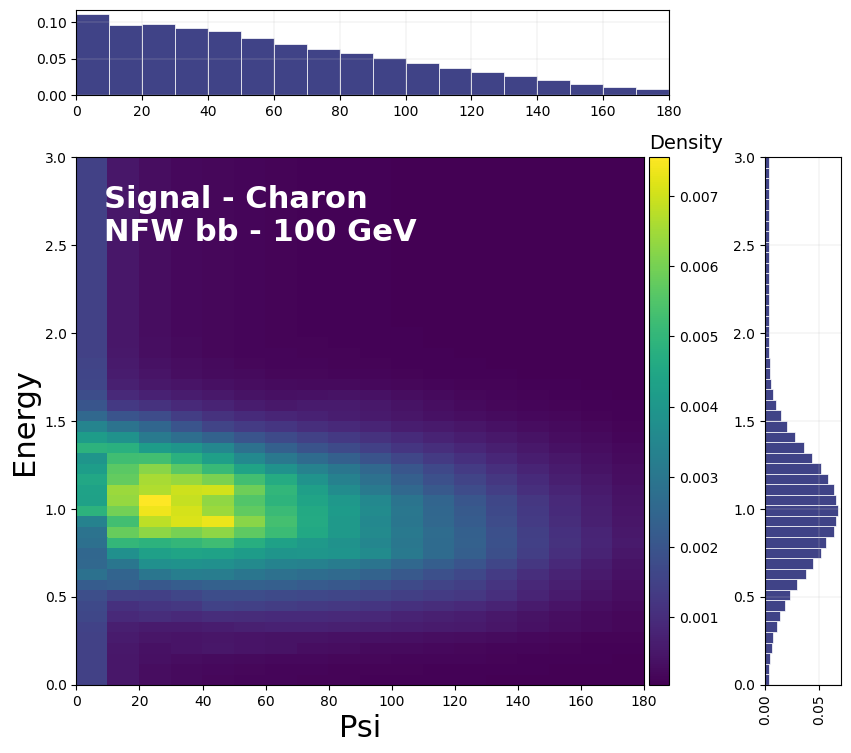

In [107]:
plot_projections(RecoRate/np.sum(RecoRate), np.array([Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass))


/tmp/ipykernel_26727/1276415146.py:17: RuntimeWarning: invalid value encountered in log10
  plot_projections(Rate['nu_mu']/np.sum(Rate['nu_mu']), np.array([Bin['true_psi_edges'], np.log10(Bin['true_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass), zlogscale=True)
/tmp/ipykernel_26727/1276415146.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(Rate['nu_mu']/np.sum(Rate['nu_mu']), np.array([Bin['true_psi_edges'], np.log10(Bin['true_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass), zlogscale=True)


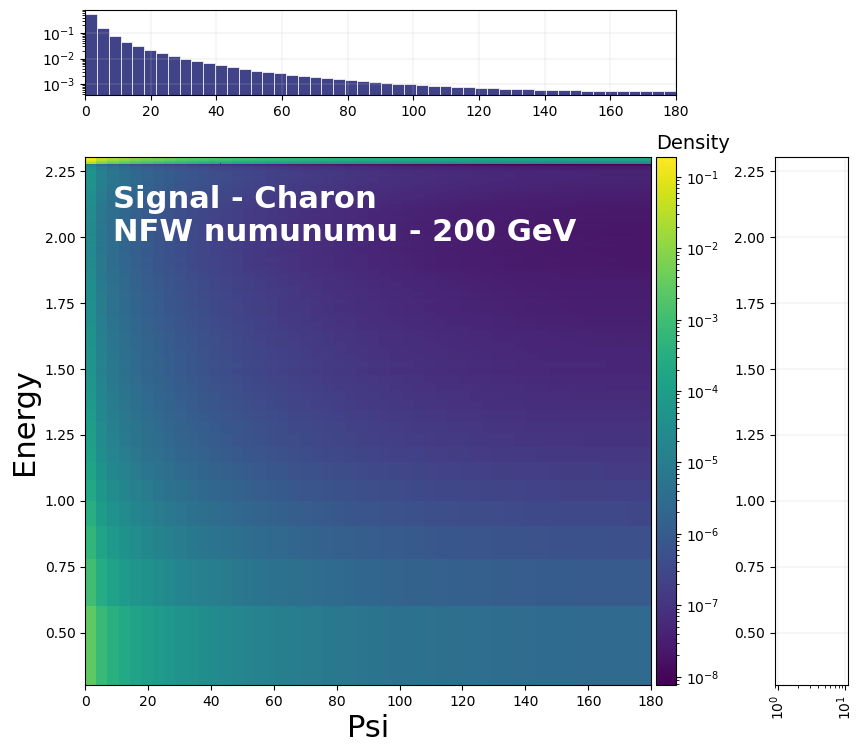

In [137]:
# channel='numunumu'
# mass=200
# pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"
# # pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_PPPC4_atEarth.pkl"

# # Precomputed Jfactor:
# pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"

# # Extract true rate:
# # Jfactor:
# Jfactor = Interpolate_Jfactor(pathJfactor, Bin['true_psi_center'])
# # Spectra:
# Spectra = Interpolate_Spectra(pathSpectra, Bin['true_energy_center'], channel, mass)

# Compute the rate as Spectra x Jfactor
Rate = TrueRate(Spectra, Jfactor)
plot_projections(Rate['nu_mu']/np.sum(Rate['nu_mu']), np.array([Bin['true_psi_edges'], np.log10(Bin['true_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass), zlogscale=True)


Interpolate on linear grid

In [4]:
Bin = Std_Binning(3100, N_Etrue=300)
Etrue_edges = pow(10., np.linspace(np.log10(1.), np.log10(3100), 301))
Etrue_center = np.array([np.sqrt(Etrue_edges[i]*Etrue_edges[i+1]) for i in range(len(Etrue_edges) - 1)])
Bin['true_energy_center']=Etrue_center
Bin['true_energy_edges']=Etrue_edges


In [5]:
set = '0000'
MC = ExtractMC(['14'+set, '12'+set, '16'+set])

In [6]:
# This will take ~ 10 minutes

# Create Response matrix (normal + Scramble)
Resp = KDE_RespMatrix(MC, Bin, 'ISJ', maxEtrue=3000, maxEreco=1000)
# Resp_Scr = KDE_RespMatrix(MC, Bin, 'ISJ', maxEtrue=mass*1.25, maxEreco=1000, Scramble=True)

Preparing evaluation grid
Etrue: [-4.96629382e-03  2.25595184e-02  5.00853307e-02  7.76111429e-02
  1.05136955e-01  1.32662767e-01  1.60188580e-01  1.87714392e-01
  2.15240204e-01  2.42766016e-01  2.70291829e-01  2.97817641e-01
  3.25343453e-01  3.52869265e-01  3.80395078e-01  4.07920890e-01
  4.35446702e-01  4.62972514e-01  4.90498327e-01  5.18024139e-01
  5.45549951e-01  5.73075763e-01  6.00601575e-01  6.28127388e-01
  6.55653200e-01  6.83179012e-01  7.10704824e-01  7.38230637e-01
  7.65756449e-01  7.93282261e-01  8.20808073e-01  8.48333886e-01
  8.75859698e-01  9.03385510e-01  9.30911322e-01  9.58437135e-01
  9.85962947e-01  1.01348876e+00  1.04101457e+00  1.06928797e+00
  1.09832926e+00  1.12815929e+00  1.15879950e+00  1.19027187e+00
  1.22259902e+00  1.25580415e+00  1.28991112e+00  1.32494442e+00
  1.36092920e+00  1.39789131e+00  1.43585729e+00  1.47485440e+00
  1.51491066e+00  1.55605482e+00  1.59831644e+00  1.64172585e+00
  1.68631425e+00  1.73211364e+00  1.77915692e+00  1.82747

KeyboardInterrupt: 

In [5]:
Resp_Scr = KDE_RespMatrix(MC, Bin, 'ISJ', maxEtrue=1500, maxEreco=1500, Scramble=True)


Preparing evaluation grid
Computing [0.0, 1.0] PID bin
----nu_e
Scrambled Response matrix
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.06408971 0.25251898 0.06471831 0.00056994]
----nu_mu
Scrambled Response matrix
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.0642285  0.27296012 0.0659274  0.00060221]
----nu_tau
Scrambled Response matrix
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.07577494 0.32251958 0.07848123 0.00073078]
----nu_e_bar
Scrambled Response matrix
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.06318997 0.2641019  0.06632568 0.00052516]
----nu_mu_bar
Scrambled Response matrix
Preparing train grid
Correct bias at boundary psi=0 using mirr

In [6]:
outdict = dict()
outdict['Bin'] = Bin
outdict['Resp'] = Resp
outdict['Resp_Scr'] = Resp_Scr
pkl.dump(outdict, open("./PreComp/Resp_MC{}.pkl".format(set), "wb"))


In [10]:
indict = pkl.load(open("./PreComp/Resp_MC{}.pkl".format('0000'), "rb"))
Resp = indict["Resp_Scr"]
Resp.keys()

dict_keys(['nu_e', 'nu_mu', 'nu_tau', 'nu_e_bar', 'nu_mu_bar', 'nu_tau_bar'])

In [9]:
def InterpolateResp_linear(RespFile, Bin):
    Evaltrue = Bin['true_energy_center']
    Evalreco = np.log10(Bin['reco_energy_center'])
    Psievaltrue = Bin['true_psi_center']
    Psievalreco = Bin['reco_psi_center']

    # Access precomputee response matrix and its grid
    
    indict = pkl.load(open(RespFile, "rb"))
    Resp = indict["Resp"]
    psitrue = indict['Bin']['true_psi_center']
    Etrue = indict['Bin']['true_energy_center']
    psireco = indict['Bin']['reco_psi_center']
    Ereco = np.log10(indict['Bin']['reco_energy_center'])

    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    Resp_interpolated = dict()
    for nu in nu_types:
        print("Getting Response Matrix for {}".format(nu))
        Resp_interpolated[nu] = EqualGridInterpolator((psitrue, Etrue, psireco, Ereco), Resp[nu], order=2)(np.meshgrid(Psievaltrue, Evaltrue, Psievalreco, Evalreco,  indexing='ij'))
    

    return Resp_interpolated

In [37]:
Bin = Std_Binning(10)
Resp = InterpolateResp_linear("./PreComp/Test2.pkl", Bin)

Getting Response Matrix for nu_e
Getting Response Matrix for nu_mu
Getting Response Matrix for nu_tau
Getting Response Matrix for nu_e_bar
Getting Response Matrix for nu_mu_bar
Getting Response Matrix for nu_tau_bar


In [41]:
channel='numunumu'
mass=10
pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"
# pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_PPPC4_atEarth.pkl"

# Precomputed Jfactor:
pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"

# Extract true rate:
# Jfactor:
Jfactor = Interpolate_Jfactor(pathJfactor, Bin['true_psi_center'])
# Spectra:
Spectra = Interpolate_Spectra(pathSpectra, Bin['true_energy_center'], channel, mass)

# Compute the rate as Spectra x Jfactor
Rate = TrueRate(Spectra, Jfactor)

/tmp/ipykernel_18118/1642302132.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(Rate['nu_mu']/np.sum(Rate['nu_mu']), np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass), zlogscale=True)


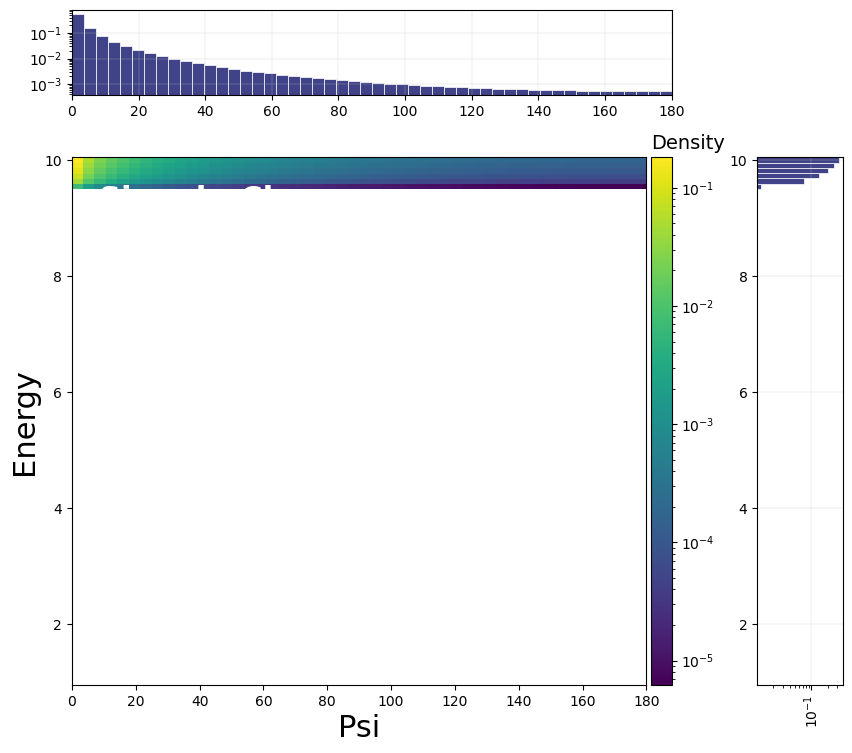

In [42]:
plot_projections(Rate['nu_mu']/np.sum(Rate['nu_mu']), np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass), zlogscale=True)


In [43]:
RecoRate = np.zeros((len(Bin['reco_psi_center']), len(Bin['reco_energy_center'])))
for nutype in ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    RecoRate += np.tensordot(Resp[nutype], Rate[nutype], axes=([0,1], [0,1]))

/tmp/ipykernel_18118/3508684325.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(RecoRate/np.sum(RecoRate), np.array([Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass))


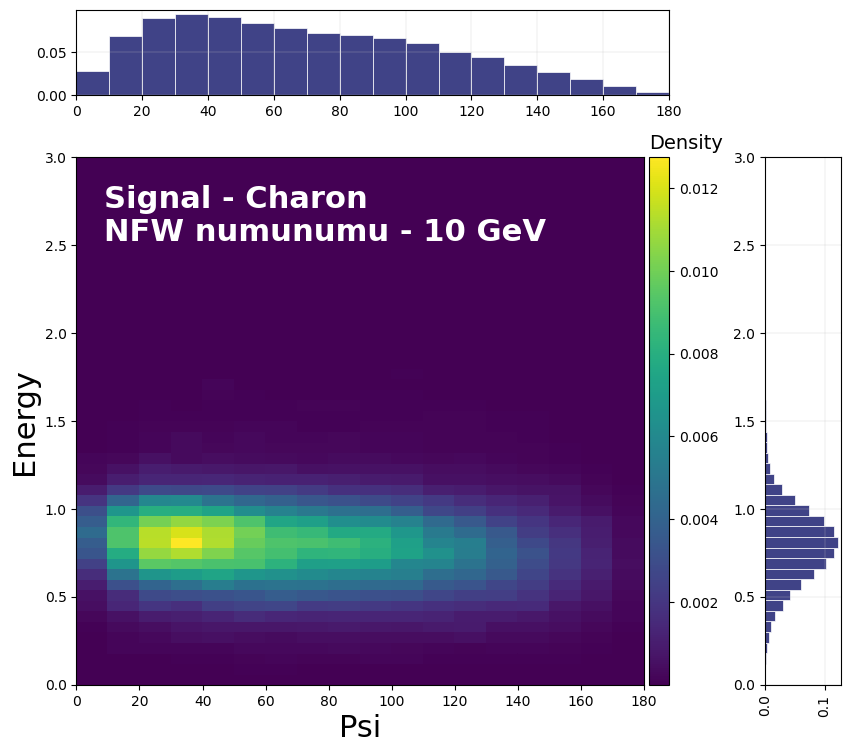

In [44]:
plot_projections(RecoRate/np.sum(RecoRate), np.array([Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass))


# <font color="darkmagenta"> log on energy and reflection on psi </font>

In [3]:
# KDE:
from KDEpy import FFTKDE
from KDEpy.bw_selection import improved_sheather_jones

In [4]:
set = '0000'
MCcut = ExtractMC(['14'+set, '12'+set, '16'+set])


In [10]:

Bin = Std_Binning(3100, N_Etrue=300, N_psitrue=100)
Etrue_edges = pow(10., np.linspace(np.log10(0.9), np.log10(3100), 301))
Etrue_center = np.array([np.sqrt(Etrue_edges[i]*Etrue_edges[i+1]) for i in range(len(Etrue_edges) - 1)])
Bin['true_energy_center']=Etrue_center
Bin['true_energy_edges']=Etrue_edges


g_psi_true, g_energy_true_0, g_psi_reco, g_energy_reco = np.meshgrid(Bin['true_psi_center'], np.log10(Bin['true_energy_center']), 
            Bin['reco_psi_center'], np.log10(Bin['reco_energy_center']), indexing='ij')



psiE_eval = np.vstack([g_psi_true.flatten(), g_energy_true_0.flatten(), g_psi_reco.flatten(), g_energy_reco.flatten()])

def Extend_grid(E_true, E_reco, maxEtrue, maxEreco, psi_true, psi_reco):
    logEtrue_width = np.log10(E_true[1]) - np.log10(E_true[0])
    while E_true[-1]<maxEtrue:
        E_true = np.append(E_true, pow(10, np.log10(E_true[-1])+logEtrue_width))
    while E_true[0]>1.:    
        E_true = np.append(pow(10, np.log10(E_true[0])-logEtrue_width), E_true)
        

    logEreco_width = np.log10(E_reco[1]) - np.log10(E_reco[0])
    while E_reco[-1]<maxEreco:
        E_reco = np.append(E_reco, pow(10, np.log10(E_reco[-1])+logEreco_width))
    while E_reco[0]>1.:    
        E_reco = np.append(pow(10, np.log10(E_reco[0])-logEreco_width), E_reco)
    

    psitrue_width = psi_true[1] - psi_true[0]
    psi_true = np.append(psi_true[0]-psitrue_width, psi_true)
    psi_true = np.append(psi_true, psi_true[-1]+psitrue_width)

    psireco_width = psi_reco[1] - psi_reco[0]
    psi_reco = np.append(psi_reco[0]-psireco_width, psi_reco)
    psi_reco = np.append(psi_reco, psi_reco[-1]+psireco_width)

    return E_true, E_reco, psi_true, psi_reco

In [12]:
Bin['true_psi_center']

array([  0.9,   2.7,   4.5,   6.3,   8.1,   9.9,  11.7,  13.5,  15.3,
        17.1,  18.9,  20.7,  22.5,  24.3,  26.1,  27.9,  29.7,  31.5,
        33.3,  35.1,  36.9,  38.7,  40.5,  42.3,  44.1,  45.9,  47.7,
        49.5,  51.3,  53.1,  54.9,  56.7,  58.5,  60.3,  62.1,  63.9,
        65.7,  67.5,  69.3,  71.1,  72.9,  74.7,  76.5,  78.3,  80.1,
        81.9,  83.7,  85.5,  87.3,  89.1,  90.9,  92.7,  94.5,  96.3,
        98.1,  99.9, 101.7, 103.5, 105.3, 107.1, 108.9, 110.7, 112.5,
       114.3, 116.1, 117.9, 119.7, 121.5, 123.3, 125.1, 126.9, 128.7,
       130.5, 132.3, 134.1, 135.9, 137.7, 139.5, 141.3, 143.1, 144.9,
       146.7, 148.5, 150.3, 152.1, 153.9, 155.7, 157.5, 159.3, 161.1,
       162.9, 164.7, 166.5, 168.3, 170.1, 171.9, 173.7, 175.5, 177.3,
       179.1])

In [ ]:
def RespMatrix_FFTkde(MCcut, Bin, mirror=True, Scramble=False, weight_cut=True):

    grid = np.meshgrid(Bin['true_psi_center'], Bin['true_energy_center'], 
            Bin['reco_psi_center'], np.log10(Bin['reco_energy_center']), indexing='ij')

    trueEeval, recoEeval, truePsieval, recoPsieval = Extend_grid(Bin["true_energy_center"], Bin["reco_energy_center"], 3100, 1000, Bin["true_psi_center"], Bin["reco_psi_center"])  
    # print('Etrue: {}'.format(trueEeval))
    # print('Ereco: {}'.format(recoEeval))
    # print('Psitrue: {}'.format(truePsieval))
    # print('Psireco: {}'.format(recoPsieval))


    g_psi_true, g_energy_true, g_psi_reco, g_energy_reco = np.meshgrid(truePsieval, trueEeval,
                                                            recoPsieval, recoEeval, indexing='ij')                      
    psi_eval_true = g_psi_true.flatten()
    E_eval_true = g_energy_true.flatten()
    psi_eval_reco = g_psi_reco.flatten()
    E_eval_reco = g_energy_reco.flatten()

    psiE_eval = np.vstack([psi_eval_true, np.log10(E_eval_true), 
            psi_eval_reco, np.log10(E_eval_reco)])



    # Separate MC by each channel nutype->PID:
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    # nu_types = ["nu_mu"]

    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}
    # PID = [[0.,0.5],[0.5, 0.85],[0.85, 1]]
    PID = [[0.,1.]]
    Resp = dict()
    pidbin = 0
    for pid in PID:
        print("Computing {} PID bin".format(pid))
        # Resp[pidbin] = dict()
        # pidbin += 1
        for nu_type in nu_types:
            print("----{}".format(nu_type))

            psireco=MCcut["psi_reco"]
            if Scramble:
                print("Scrambled Response matrix")
                RAreco = MCcut["RA_reco"]
                Decreco = MCcut["Dec_reco"]
                # Create scramble RA:
                RAreco_Scr = np.random.uniform(0,2.*np.pi, size=len(RAreco))
                # Get correct psi from scramble RA and original DEC
                psireco = np.rad2deg(psi_f(RAreco_Scr, Decreco))

            loc = np.where(  (MCcut["nutype"]==pdg_encoding[nu_type]) & (MCcut["PID"]>=pid[0])
                            & (MCcut["PID"]<pid[1]) 
                            & (MCcut["E_reco"] < 1000)
                            & (MCcut["E_reco"] > np.min(Bin["reco_energy_center"]))
                            & (MCcut["E_true"] < 3100)
                            & (MCcut["E_true"] > np.min(Bin["true_energy_center"]))
                            # & (MCcut["psi_true"] < np.max(Bin["true_psi_center"]))
                            # & (MCcut["psi_true"] > np.min(Bin["true_psi_center"]))
                            # & (psireco < np.max(Bin["reco_psi_center"]))
                            # & (psireco > np.min(Bin["reco_psi_center"]))
                            )
        
            #Extract MC events: 
            #NOTE: input psi in deg!
            psitrue = MCcut["psi_true"][loc]
            Etrue = MCcut["E_true"][loc]
            psireco = psireco[loc]
            Ereco = MCcut["E_reco"][loc]
            w = MCcut["w"][loc]        

            if weight_cut:
                w_lim = define_weightcut(w, 200) #Previously 200
                print ("##Applying cut on weight##")
                print ("Weight lim:", w_lim)
                w_loc = np.where(w<=w_lim)
                #Renormalise weight for total weight to be unchanged
                w = w[w_loc] * (np.sum(w)/np.sum(w[w_loc]))
                psitrue = psitrue[w_loc]
                Etrue = Etrue[w_loc]
                psireco = psireco[w_loc]
                Ereco = Ereco[w_loc]



            print("Preparing train grid")    
            # psiE_train = np.vstack([np.log(psitrue), Etrue, np.log(psireco), np.log10(Ereco)])
            
            psiE_train = np.vstack([psitrue, np.log10(Etrue), psireco, np.log10(Ereco)])

            if mirror:
                psiE_train=MirroringData(psiE_train, {0:0, 2:0})
                w=np.concatenate((w,w))
                print("Correct bias at boundary psi=0 using mirror data (reflection)")
                # extend grid point to contain the mirror data
                recoPsieval_width = recoPsieval[1] - recoPsieval[0]
                while recoPsieval[0]>-180.:
                    recoPsieval=np.append(recoPsieval[0]-recoPsieval_width, recoPsieval)
                
                truePsieval_width = truePsieval[1] - truePsieval[0]
                while truePsieval[0]>-180.:
                    truePsieval=np.append(truePsieval[0]-truePsieval_width, truePsieval)
                
                g_psi_true, g_energy_true, g_psi_reco, g_energy_reco = np.meshgrid(truePsieval, trueEeval,
                                                            recoPsieval, recoEeval, indexing='ij')                      
                psi_eval_true = g_psi_true.flatten()
                E_eval_true = g_energy_true.flatten()
                psi_eval_reco = g_psi_reco.flatten()
                E_eval_reco = g_energy_reco.flatten()

                psiE_eval = np.vstack([psi_eval_true, np.log10(E_eval_true), 
                        psi_eval_reco, np.log10(E_eval_reco)]) 


            print("Evaluating KDE.....")    

            kde_w = kde_FFT(psiE_train.T, psiE_eval.T, bandwidth='ISJ', weights=w)
            #Needs to be divided by evaluation angle
            # kde_weight = kde_w.reshape(psi_eval_true.shape)
            # kde_weight = kde_w/(psi_eval_true * psi_eval_reco)
            kde_weight = kde_w
                                    
            # Fill into histogram:
            Psitrue_edges = Bin["true_psi_edges"]
            Etrue_edges = Bin["true_energy_edges"]
            Psireco_edges = Bin["reco_psi_edges"]
            Ereco_edges = Bin["reco_energy_edges"]

            H, edges = np.histogramdd((psi_eval_true, E_eval_true, psi_eval_reco, E_eval_reco),
                                bins = (Psitrue_edges, Etrue_edges, Psireco_edges, Ereco_edges),
                                weights=kde_weight)

            # N = np.histogramdd((psi_eval_true, E_eval_true, psi_eval_reco, E_eval_reco),
            #                     bins = (Psitrue_edges, Etrue_edges, Psireco_edges, Ereco_edges))
            # if np.min(N)==0:
            #     return 'There is an empty bin!!'                    
            # H = H/N[0]
            H = H/grid[1]
            if mirror:
                norm = np.sum(w)/(2*np.sum(H))
            else:
                norm = np.sum(w)/np.sum(H) 
            Resp[nu_type] = H*norm
    return Resp

Resp = RespMatrix_FFTkde(MCcut, Bin, mirror=True, Scramble=False, weight_cut=True)

Computing [0.0, 1.0] PID bin
----nu_e
##Applying cut on weight##
Weight lim: 692.0987625039502
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
bandwidth: 0.018653515349646613


In [21]:
outdict = dict()
outdict['Bin'] = Bin
outdict['Resp'] = Resp
# outdict['Resp_Scr'] = Resp_Scr
pkl.dump(outdict, open("/data/user/tchau/Sandbox/GC_OscNext/DetResponse/PreComp/Resp_MC{}_logE.pkl".format(set), "wb"))

In [2]:
def InterpolateResp_logE(RespFile, Bin):
    Evaltrue = Bin['true_energy_center']
    Evalreco = Bin['reco_energy_center']
    Psievaltrue = Bin['true_psi_center']
    Psievalreco = Bin['reco_psi_center']

    # Access precomputee response matrix and its grid
    
    indict = pkl.load(open(RespFile, "rb"))
    Resp = indict["Resp"]
    psitrue = indict['Bin']['true_psi_center']
    Etrue = indict['Bin']['true_energy_center']
    psireco = indict['Bin']['reco_psi_center']
    Ereco = indict['Bin']['reco_energy_center']

    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    Resp_interpolated = dict()
    for nu in nu_types:
        print("Getting Response Matrix for {}".format(nu))
        Resp_interpolated[nu] = EqualGridInterpolator((psitrue, np.log10(Etrue), psireco, np.log10(Ereco)), Resp[nu], order=1)(np.meshgrid(Psievaltrue, np.log10(Evaltrue), Psievalreco, np.log10(Evalreco),  indexing='ij'))
        # Resp_interpolated[nu] = pow(10., Resp_interpolated[nu])

    return Resp_interpolated

In [23]:
test = pkl.load(open('/data/user/tchau/Sandbox/GC_OscNext/DetResponse/PreComp/Resp_MC0000_logE.pkl', 'rb'))

In [24]:
test.keys()

dict_keys(['Bin', 'Resp'])

In [22]:
test['Resp']['nu_tau'].shape

(50, 300, 18, 50)

In [28]:
np.min(Resp['nu_e'][1,1,0:18,0:50])

1.210763869397058e-06

In [47]:
Bin['true_psi_center'][1]
Bin['true_energy_center'][100]

14.777676918650748

In [30]:
test2 = pkl.load(open('/data/user/tchau/Sandbox/GC_OscNext/DetResponse/PreComp/Resp_MC0000_logE.pkl', 'rb'))

In [35]:
test2['Resp'].keys()

AttributeError: 'NoneType' object has no attribute 'keys'

In [31]:
plot_projections(test2['Resp']['nu_e'][25,100,0:18,0:50], np.array([Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])]), "Psi", "Energy", "Resp")


TypeError: 'NoneType' object is not subscriptable

In [191]:
test2['Bin']['true_psi_center'][1]
test2['Bin']['true_energy_center'][5]

1.0449360067214803

In [26]:
# First the signal pdf
# channel and mass
from Signal import *
channel = "bb"
mass = 600
profile='NFW'
# Bin
bin = Std_Binning(mass, N_Etrue=100)
# Bin['reco_psi_edges'] = np.linspace(20,180, 19)
# Bin['reco_psi_center'] = np.linspace(20,180, 18)

# Bin = GroupBinning(pow(10.,Edge[1]), pow(10.,Edge[0]), pow(10., logEtrue), pow(10., logpsitrue), pow(10.,Edge[3]), pow(10.,Edge[2]), pow(10., logEreco), pow(10., logpsireco), [0,1], 0.5)
Reco = RecoRate(channel, 
            mass, 
            profile,
            bin,
            type="Resp",
            spectra='PPPC4')

In [27]:
RespInt = InterpolateResp_logE("/data/user/tchau/Sandbox/GC_OscNext/DetResponse/PreComp/Resp_MC0000_logE.pkl", bin)

Getting Response Matrix for nu_e
Getting Response Matrix for nu_mu
Getting Response Matrix for nu_tau
Getting Response Matrix for nu_e_bar
Getting Response Matrix for nu_mu_bar
Getting Response Matrix for nu_tau_bar


In [28]:
Rate = Reco.ComputeTrueRate()
Rate.keys()

********************
Computing true rate with PPPC4 spectra
channel: bb || mass: 600 || profile: NFW || process: ann



dict_keys(['nu_e', 'nu_mu', 'nu_tau', 'nu_e_bar', 'nu_mu_bar', 'nu_tau_bar'])

In [29]:
RecoRate = np.zeros((len(bin['reco_psi_center']), len(bin['reco_energy_center'])))
for nutype in [ "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    RecoRate += np.tensordot(RespInt[nutype], Rate[nutype], axes=([0,1], [0,1]))

/tmp/ipykernel_21298/4071698715.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(RecoRate/np.sum(RecoRate), np.array([bin['reco_psi_edges'], np.log10(bin['reco_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass))


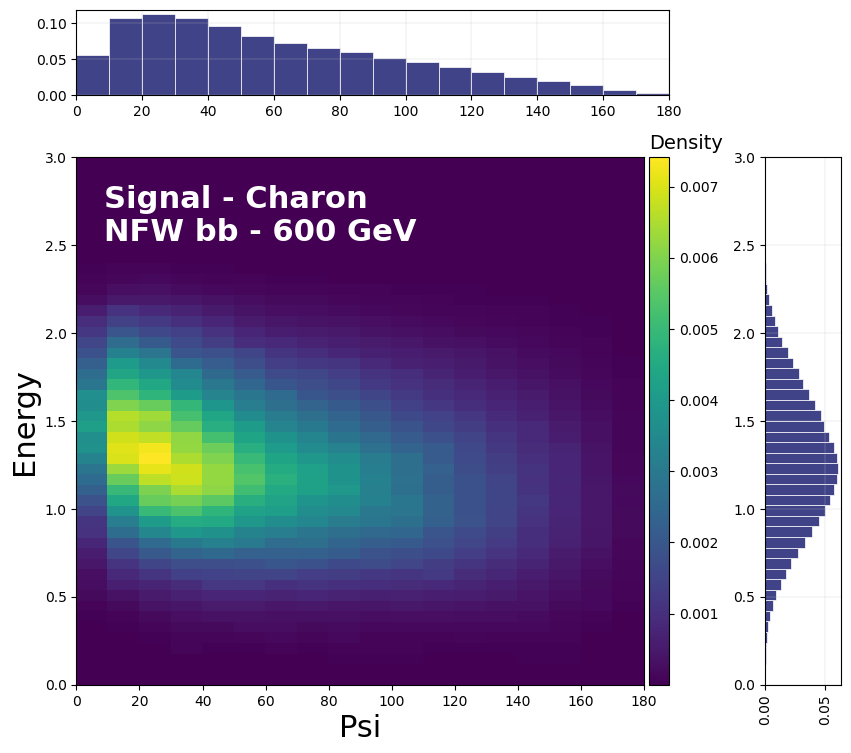

In [30]:
plot_projections(RecoRate/np.sum(RecoRate), np.array([bin['reco_psi_edges'], np.log10(bin['reco_energy_edges'])]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass))

/tmp/ipykernel_8905/2710622028.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(Rate['nu_mu']/np.sum(Rate['nu_mu']), np.array([bin['true_psi_edges'], bin['true_energy_edges']]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass), zlogscale=True)


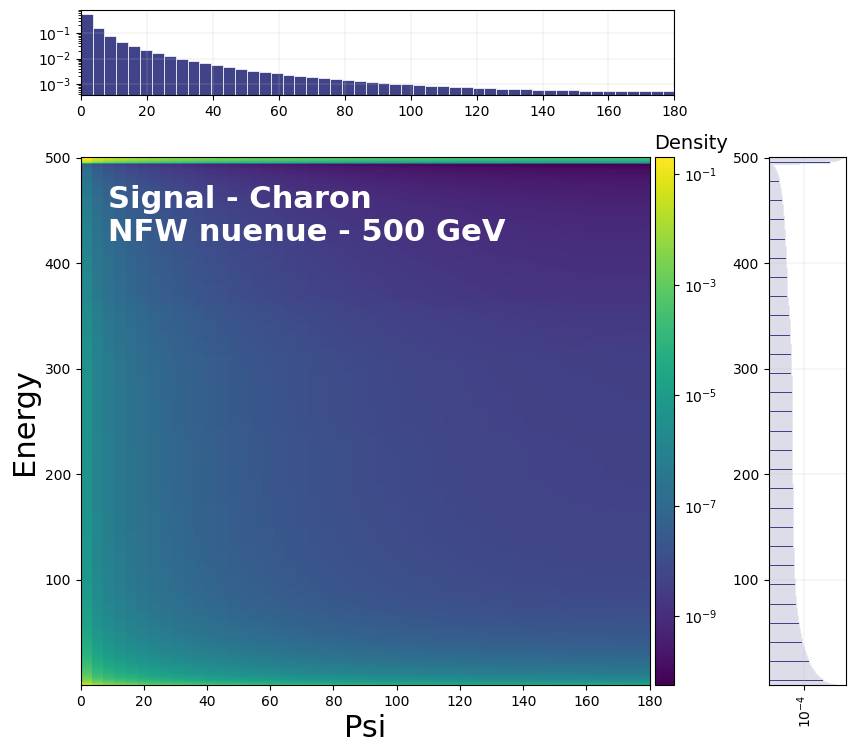

In [175]:
plot_projections(Rate['nu_mu']/np.sum(Rate['nu_mu']), np.array([bin['true_psi_edges'], bin['true_energy_edges']]), "Psi", "Energy", "Signal - Charon" "\n" "NFW {} - {} GeV".format(channel, mass), zlogscale=True)
